In [4]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

In [ ]:
from langchain_core.messages import HumanMessage, AIMessage
from pprint import pprint

messages = [
    AIMessage(content="Please, tell me how can I help.", name="LLMModel"),
    HumanMessage(content="I want to learn coding", name="Krish"),
    AIMessage(content="Which programming language you want to learn?", name="LLMModel"),
    HumanMessage(content="I want to learn Python Programming language", name="Krish")
]

for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: LLMModel

Please, tell me how can I help.
================================ Human Message =================================
Name: Krish

I want to learn coding
================================== Ai Message ==================================
Name: LLMModel

Which programming language you want to learn?
================================ Human Message =================================
Name: Krish

I want to learn Python Programming language


In [15]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="qwen/qwen3-32b")
llm.invoke(messages)

AIMessage(content='<think>\nOkay, the user wants to learn Python. Let me start by thinking about the best way to guide them. First, they probably need an introduction to what Python is and why it\'s useful. I should mention that it\'s versatile for web dev, data science, automation, etc.\n\nNext, the basics. They\'ll need to install Python. Maybe suggest checking the official website for the latest version. Also, a code editor—Visual Studio Code is popular, but maybe also mention PyCharm or even simpler ones like Thonny for beginners.\n\nThen, the first steps: writing a "Hello, World!" program. That\'s classic and gets them comfortable with running code. Then moving into variables, data types, and operators. Basic syntax is crucial here.\n\nControl structures like if-else and loops are next. Functions are important too. Maybe explain how to define and use them. Then data structures—lists, tuples, dictionaries. These are fundamental in Python.\n\nI should also think about common pitfall

In [50]:
from langchain.tools import tool

@tool
def add(a: int, b: int) -> int:
    """
    Add two numbers
    Args:
        a (int): First number
        b (int): Second number
    
    Returns:
        int: Sum of the two numbers
    """
    return a + b

In [51]:
llm_with_tools =llm.bind_tools([add])

llm_with_tools.invoke([HumanMessage(content="What is 1 + 1?")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking "What is 1 + 1?" I need to use the add function provided. Let me check the function parameters. The add function takes two integers, a and b. So, in this case, a is 1 and b is 1. I should return the sum, which would be 2. Let me make sure I\'m formatting the tool call correctly. The tool call should be a JSON object inside XML tags. Alright, the name is "add" and the arguments are {"a": 1, "b": 1}. That should do it.\n', 'tool_calls': [{'id': '33hrecb3a', 'function': {'arguments': '{"a":1,"b":1}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 152, 'prompt_tokens': 194, 'total_tokens': 346, 'completion_time': 0.258354925, 'completion_tokens_details': {'reasoning_tokens': 123}, 'prompt_time': 0.008750173, 'prompt_tokens_details': None, 'queue_time': 0.047629997, 'total_time': 0.267105098}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921

In [52]:
## Messages as State
from pydantic import BaseModel
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class State(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]


In [53]:
# add_messages as reducer

initial_messages = [
    AIMessage(content="Please, tell me how can I help.", name="LLMModel"),
    HumanMessage(content="I want to learn coding", name="Krish")
]
ai_message = AIMessage(content="Which programming language you want to learn?", name="LLMModel")

add_messages(initial_messages, ai_message)


[AIMessage(content='Please, tell me how can I help.', additional_kwargs={}, response_metadata={}, name='LLMModel', id='d86c8778-b588-4d5c-8b4c-d4b4b84adbb6', tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Krish', id='34d50c42-975a-431e-a638-08e408e22110'),
 AIMessage(content='Which programming language you want to learn?', additional_kwargs={}, response_metadata={}, name='LLMModel', id='0277b3a7-4391-4870-b8e7-34d8b169c518', tool_calls=[], invalid_tool_calls=[])]

In [57]:
# Chatbot node functionality
def llm_tool(state: State):
    return {"messages": [llm_with_tools.invoke(state.messages)]}

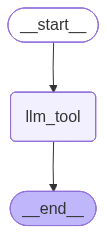

In [58]:
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image

builder = StateGraph(State)

builder.add_node("llm_tool", llm_tool)

builder.add_edge(START, "llm_tool")
builder.add_edge("llm_tool", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [62]:
msgs = graph.invoke({"messages": "What is 2+2?"})

for msg in msgs["messages"]:
    msg.pretty_print()

================================ Human Message =================================

What is 2+2?
================================== Ai Message ==================================
Tool Calls:
  add (h1ymk825q)
 Call ID: h1ymk825q
  Args:
    a: 2
    b: 2


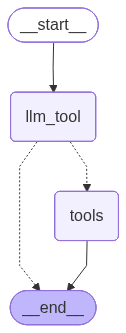

In [69]:
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(State)

# add node
builder.add_node("llm_tool", llm_tool)
builder.add_node("tools", ToolNode(tools=[add]))

builder.add_edge(START, "llm_tool")
# If the latest message (result) from the assistant is a tool call -> tools_condition routes to tools
# If the latest message (result) from the assistant is not a tool call -> tools_condition routes to END
builder.add_conditional_edges("llm_tool", tools_condition)
builder.add_edge("tools", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [70]:
msgs = graph.invoke({"messages": "What is 5+2?"})

for msg in msgs["messages"]:
    msg.pretty_print()

================================ Human Message =================================

What is 5+2?
================================== Ai Message ==================================
Tool Calls:
  add (10hmywxpv)
 Call ID: 10hmywxpv
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: add

7
